# Timing, profiling and compiling

## Timing

In [1]:
import numpy as np
import time
rng = np.random.default_rng(3945)

A straightforward way to time code is to read the current time with `time.time()`. For example, consider the following matrix multiplication:

In [2]:
n = 10**3
A = rng.normal(size = (n,n))

t_start = time.time()
B = A@A
t_end = time.time()

print('Time taken = ', t_end-t_start)
print('GFLOPS = ', 2*n**3 / (t_end-t_start) / 1e9)

Time taken =  0.02085590362548828
GFLOPS =  95.89610864694316


As well as the time taken, this also outputs the number of floating point operations per second (in units of $10^9$ FLOPS or GFLOPS). I've used the fact that for each element of the new matrix we have to do $n$ multiplications and $\approx n$ additions, so we expect the total number of operations to be $2n^3$.

In [3]:
%%timeit -n 3 -r 10
# -n gives the number of times to run for each time measurement
# -r is the number of times to repeat the time measurement
B = A@A

20.8 ms ± 4.67 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


```{admonition} Question
Does the number of GFLOPS we obtain here make sense? What should it be? How does it depend on $N$?
```

## Profiling

In [4]:
import matplotlib.pyplot as plt
import scipy.integrate

We can also look in more detail at which parts of the code take the most time. This is known as *profiling*. As an example, let's take a look at the code from the homework solutions that solves the Ising model.

In [5]:
def run_ising(beta):
    
    N = 30
    Nspins = N*N
    ntrials = 10**5

    # Populate the array with random spins (+1 or -1)
    #spins = -1 + rng.integers(2, size = Nspins) * 2
    spins = np.ones(Nspins)

    M = np.zeros(ntrials)
    M[0] = np.sum(spins)/Nspins  # starting point

    # Compute the random numbers to use for accepting the jump in advance
    u = rng.uniform(size=ntrials)
    
    for i in range(ntrials-1):
        
        # Choose spin at random
        j = rng.integers(Nspins)
        
        # Compute energy change if this spin were to flip
        delta_E = 2*spins[j] * (spins[j-1] + spins[(j+1) % Nspins] + spins[j-N] + spins[(j+N) % Nspins])
    
        # Attempt flip
        if u[i] <= np.exp(-beta*delta_E):
            spins[j] = -spins[j]
        
        # Store magnetization
        M[i+1] = np.sum(spins)/Nspins
        
    # remove the first 20% (burn in)
    return M[int(ntrials/5):]

T =  1.0
T =  1.5000000000000004
T =  2.000000000000001
T =  2.5000000000000013
T =  3.0000000000000018
T =  3.500000000000002
T =  4.000000000000003


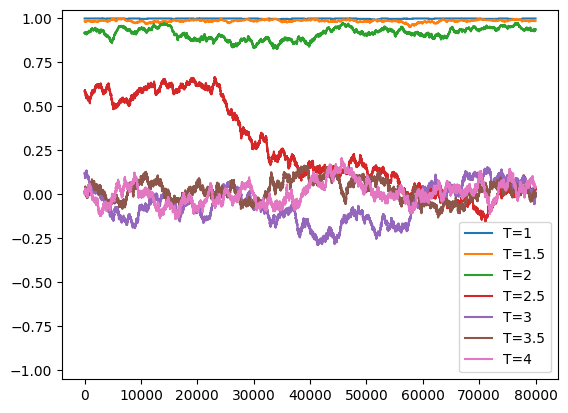

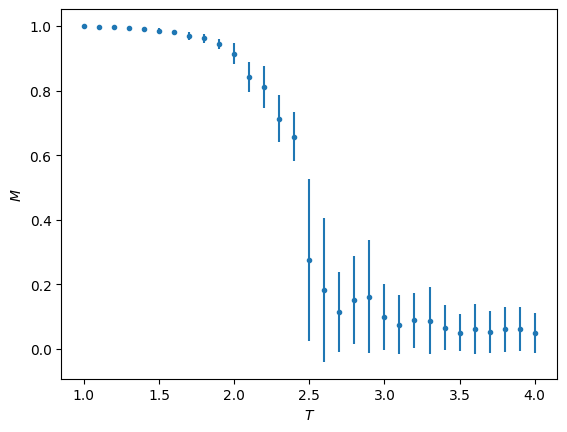

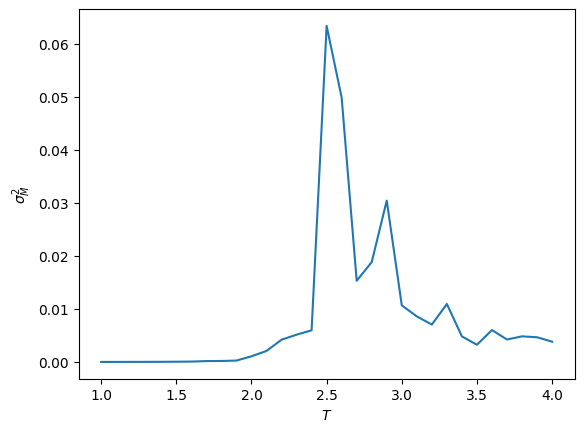

In [6]:
%%prun -q

T_vals = np.arange(1.0,4.05,0.1)

M_vals = np.zeros_like(T_vals)
chi_vals = np.zeros_like(T_vals)

for i, T in enumerate(T_vals):
    M = run_ising(1/T)
    M_vals[i] = np.mean(np.abs(M))
    chi_vals[i] = np.var(M)

    if (abs(np.floor(T*2)-(T*2))<1e-5):
        print("T = ", T)
        t = np.arange(len(M))
        plt.plot(t, M, label = "T=%g" % (T,))
        
plt.ylim((-1.05,1.05))
plt.legend()
plt.show()
        
plt.clf()
plt.errorbar(T_vals, M_vals, np.sqrt(chi_vals), fmt='.')
plt.ylabel(r'$M$')
plt.xlabel(r'$T$')
plt.show()

plt.clf()
plt.plot(T_vals, chi_vals)
plt.ylabel(r'$\sigma_M^2$')
plt.xlabel(r'$T$')
plt.show()


## Compiling python

Python can be slow because it is an interpreted rather than compiled language. As an example, let's write our own implementation of matrix multiplication:

In [7]:
def matrix_multiply(A):
    n = np.shape(A)[0]
    B = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                B[i,j] += A[i,k] * A[k,j]
    return B

n = 200
A = rng.normal(size = (n,n))

t_start = time.time()
B = matrix_multiply(A)
t_end = time.time()

print('Time taken = ', t_end-t_start)
print('GFLOPS = ', 2*n**3 / (t_end-t_start) / 1e9)

Time taken =  2.0241360664367676
GFLOPS =  0.007904606940859442


One way to pre-compile python code is to use Cython. Let's give it a try: 

In [8]:
%load_ext Cython

In [14]:
%%cython
import numpy as np

def matrix_multiply_cython(A):
    n = np.shape(A)[0]
    B = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                B[i,j] += A[i,k] * A[k,j]
    return B

In [10]:
n = 100
A = rng.normal(size = (n,n))
#B = np.zeros_like(A)

t_start = time.time()
B = matrix_multiply_cython(A)
t_end = time.time()

print('Time taken = ', t_end-t_start)
print('GFLOPS = ', 2*n**3 / (t_end-t_start) / 1e9)

Time taken =  0.2502720355987549
GFLOPS =  0.007991304322974669


*Just in time* (JIT) compilation using Numba:

In [11]:
import numba as nb

@nb.njit(parallel = False)
def matrix_multiply(A):
    n = np.shape(A)[0]
    B = np.zeros((n,n))
    # note the use of prange in the next line for parallel loops
    for i in nb.prange(n):
        for k in range(n):
            for j in range(n):
                B[i,j] += A[i,k] * A[k,j]
    return B

n = 10**3
A = rng.normal(size = (n,n))

t_start = time.time()
B = matrix_multiply(A)
t_end = time.time()

print('Time taken = ', t_end-t_start)
print('GFLOPS = ', 2*n**3 / (t_end-t_start) / 1e9)

t_start = time.time()
B = matrix_multiply(A)
t_end = time.time()

print('Time taken = ', t_end-t_start)
print('GFLOPS = ', 2*n**3 / (t_end-t_start) / 1e9)

Time taken =  0.40538668632507324
GFLOPS =  4.933561134260416
Time taken =  0.16279816627502441
GFLOPS =  12.285150660857468


Setting `parallel = True` will use multiple cores with a significant speed up. It is also possible to use parallelism in Cython with OpenMP.

## Other examples

In [12]:
# Illustration of memory ordering
n = 10**4
A = rng.uniform(size = (n,n))
x = rng.uniform(size = n)

t_start = time.time()
for i in range(n):
    b = x * A[i,:]
t_end = time.time()

print('Time taken = ', t_end-t_start)

t_start = time.time()
for i in range(n):
    b = x * A[:,i]
t_end = time.time()

print('Time taken = ', t_end-t_start)

Time taken =  0.049217939376831055
Time taken =  0.24639296531677246


In [13]:
# Using built-in parallelization in scipy fft instead of numpy fft
n = 10**4
A = rng.uniform(size = (n,n))

t_start = time.time()
B = np.fft.fft(A)
t_end = time.time()
print('Time taken = ', t_end-t_start)

t_start = time.time()
B = scipy.fft.fft(A)
t_end = time.time()
print('Time taken = ', t_end-t_start)

t_start = time.time()
B = scipy.fft.fft(A, workers=8)
t_end = time.time()
print('Time taken = ', t_end-t_start)

Time taken =  0.6787912845611572
Time taken =  0.5426170825958252
Time taken =  0.2779049873352051


## Further reading

- [timeit()](https://docs.python.org/3/library/timeit.html) documentation which has details of how to call it directly from within your code or the command line.
- [Floating-Point Operations Per Second (FLOPS)](https://en.wikichip.org/wiki/flops) for different architectures.
- [cProfile documentation](https://docs.python.org/3/library/profile.html)
- [%prun](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun)
- [tracemalloc](https://docs.python.org/3/library/tracemalloc.html) to profile memory usage
- [Cython](https://cython.readthedocs.io/en/latest/index.html#)
- [Cython for NumPy users](http://docs.cython.org/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial)
- [Cython compiler directives](https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiler-directives)
- [Parallelism in cython](https://cython.readthedocs.io/en/latest/src/userguide/parallelism.html)
- [Numba](https://numba.pydata.org)
- [PyPy](https://www.pypy.org)
- [ctypes](https://docs.python.org/3/library/ctypes.html)
- [f2py](https://numpy.org/doc/stable/f2py/)
- [multiprocessing](https://docs.python.org/3/library/multiprocessing.html)